# 이미지 90도씩 회전

In [8]:
from PIL import Image, ImageOps
import cv2
import numpy as np
import pandas as pd
import os

# 입력 이미지 디렉토리와 출력 디렉토리 경로 설정
input_csv = './data/train_correct_labeling.csv'
output_csv = './data/train_big.csv'
input_dir = './data/train'
output_dir = './data/train_big'

# 새로운 폴더 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 크롭할 클래스 리스트

# CSV 파일 읽기
df = pd.read_csv(input_csv)

# 패딩을 추가하여 맞출 최종 이미지 크기
# final_size = (128, 128)

# 새로운 CSV 파일에 기록할 리스트 초기화
processed_data = []
def load_image(image_path):
    # 이미지 로드
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return image

def rotation_image(image,angle):
    if angle==0:
        return image
   # 회전 행렬 계산
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 새 이미지 크기 계산 (여유 공간 추가)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
 
    # 회전 행렬 조정 (중심점 변경)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # 이미지 회전 및 크기 조정
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    
    return rotated

def process_image(image_path,angle):
    # 이미지 로드
    image = load_image(image_path)

    # 이미지 전처리 및 복원
    rotated = rotation_image(image,angle)
    
    return rotated

angles=[0, 90,180,270]
# 각 행에 대해 반복
for index, row in df.iterrows():
    file_name = row['ID']
    target = row['target']
    image_path = os.path.join(input_dir, file_name)
    # print(f"Processed image saved to: {index}")

    for angle in angles:
        processed_image = process_image(image_path,angle)
        # 이미지 저장
        if angle == 0:
            processed_file_name=file_name
        else:
            processed_file_name = f'rot{angle}_{file_name}'
        processed_image_path = os.path.join(output_dir, processed_file_name)
        cv2.imwrite(processed_image_path,processed_image)

        # 새로운 CSV 파일에 기록할 데이터 추가
        processed_data.append({'ID': processed_file_name, 'target': target})
try:
    ori_df = pd.read_csv(output_csv)
except:
    ori_df = pd.read_csv(input_csv)

    new_df = pd.concat([ori_df,pd.DataFrame(processed_data)],ignore_index=True)
    new_df.to_csv(output_csv,index=False)
    print(new_df.shape)


(7850, 2)


# 모든 이미지 (위에서 회전한 이미지까지 ) 플립

In [4]:
import os
from PIL import Image
from torchvision import transforms
import pandas as pd

# 이미지 플립 및 저장 함수
def flip_and_save_images(input_csv, output_csv, input_dir, output_dir):
    df = pd.read_csv(input_csv)

    # 출력 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 이미지 전처리 및 플립 설정
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0)  # 100% 확률로 좌우 플립
    ])
    image_list = []
    # 입력 디렉토리의 모든 이미지 파일에 대해 작업 수행
    for idx, row in df.iterrows():
        file_name = row['ID']
        img_path = os.path.join(input_dir, file_name)
        img = Image.open(img_path).convert("RGB")
        
        # 이미지 플립
        flipped_img = transform(img)
        
        img_name = 'flipped_'+file_name
        # 플립된 이미지 저장
        flipped_img.save(os.path.join(output_dir, img_name))
        image_list.append({'ID':img_name,'target':row['target']})

    try:
        ori_df = pd.read_csv(output_csv)
    except:
        ori_df = pd.read_csv(input_csv)

    new_df = pd.concat([ori_df,pd.DataFrame(image_list)],ignore_index=True)
    new_df.to_csv(output_csv,index=False)
    print(new_df.shape)


# 입력 이미지 디렉토리와 출력 디렉토리 경로 설정
output_csv = './data/train_big.csv'
output_dir = './data/train_big'


# 이미지 플립 및 저장 수행
flip_and_save_images(output_csv, output_csv, output_dir, output_dir)

(12560, 2)


# 용중님 코드로 이미지 사이즈를 384로 맞춤.

* 이건 제가 밑에서 노이즈를 줄건데 노이즈를 주는 파일을 하나 정해놓고 크기도 정해놔서 편하게 사이즈 맞추고 들어갑니다.

In [5]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_image_for_ocr(image_path, output_size, background_color=(255, 255, 255)):
    # 이미지 읽기 (PIL 사용)
    image = Image.open(image_path)
    
    # 리사이즈
    original_size = image.size
    ratio = min(output_size / original_size[0], output_size / original_size[1])
    new_size = tuple([int(x * ratio) for x in original_size])
    resized_image = image.resize(new_size, Image.BILINEAR)
    
    # 정사각형 백그라운드 이미지 생성 (백그라운드 컬러: 흰색)
    new_image = Image.new("RGB", (output_size, output_size), background_color)
    
    # 리사이즈된 이미지 중앙에 배치
    paste_position = ((output_size - new_size[0]) // 2, (output_size - new_size[1]) // 2)
    new_image.paste(resized_image, paste_position)
    
    # 이미지 대비 조정 및 샤프닝
    enhancer = ImageEnhance.Contrast(new_image)
    new_image = enhancer.enhance(1.2)  # 대비 약간 증가
    enhancer = ImageEnhance.Sharpness(new_image)
    new_image = enhancer.enhance(1.2)  # 선명도 약간 증가
    
    return new_image

def process_dataset(csv_path, input_folder, output_folder, output_size):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path)
    image_column = df.columns[0]  # 첫 번째 열을 이미지 파일명으로 가정
    
    # 출력 폴더 생성
    os.makedirs(output_folder, exist_ok=True)
    
    # 모든 이미지에 대해 전처리 적용
    for index, row in df.iterrows():
        image_file = row[image_column]
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)  # 'preprocessed_' 접두사 제거
        
        try:
            # 전처리 함수 호출
            preprocessed_image = preprocess_image_for_ocr(input_path, output_size, background_color=(255, 255, 255))
            
            # 전처리된 이미지 저장
            preprocessed_image.save(output_path, 'JPEG', quality=95, optimize=True)
            print(f"Preprocessed: {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
    
    print("Preprocessing completed.")

def analyze_image_sizes(folder_path):
    widths = []
    heights = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
    
    return pd.DataFrame({'Width': widths, 'Height': heights})


IMAGE_SIZE = 384
input_folder = './data/train_big/'
output_folder = './data/train_big_preprocessed/'
csv_path = './data/train_big.csv'

# 데이터셋 전처리
process_dataset(csv_path, input_folder, output_folder, IMAGE_SIZE)

# input_folder = './data/test_modify/'
# output_folder = './data/test_modify_preprocessed/'
# csv_path = './data/sample_submission.csv'

# # 데이터셋 전처리
# process_dataset(csv_path, input_folder, output_folder, IMAGE_SIZE)

Preprocessed: 002f99746285dfdd.jpg
Preprocessed: 008ccd231e1fea5d.jpg
Preprocessed: 008f5911bfda7695.jpg
Preprocessed: 009235e4c9c07af5.jpg
Preprocessed: 00b2f44967580c74.jpg
Preprocessed: 00cfa88ce8973dea.jpg
Preprocessed: 00ec594b7cc89183.jpg
Preprocessed: 00f59b12e9e08f29.jpg
Preprocessed: 00fdc02d9b552fe8.jpg
Preprocessed: 012913977fd1d980.jpg
Preprocessed: 0134204c33c8d37c.jpg
Preprocessed: 0143de5f1099427d.jpg
Preprocessed: 01af3d4c58c8530f.jpg
Preprocessed: 01c0b97e1492b220.jpg
Preprocessed: 024fe478044874ab.jpg
Preprocessed: 0250ee8107091ade.jpg
Preprocessed: 02533d35fe935981.jpg
Preprocessed: 026817f3f9434f5b.jpg
Preprocessed: 02ab86a5d5a979cc.jpg
Preprocessed: 02d404271e4965fa.jpg
Preprocessed: 02dad82a9420ae86.jpg
Preprocessed: 02e1538cef751c7d.jpg
Preprocessed: 02ebb92c43006832.jpg
Preprocessed: 03075ea3046d4459.jpg
Preprocessed: 03084c1b03921a99.jpg
Preprocessed: 03636653282bb56c.jpg
Preprocessed: 03648b6855b9f8c1.jpg
Preprocessed: 03ce6a0a86939c04.jpg
Preprocessed: 040073

# 노이즈 주기

* graynoise.jpg 파일이 필요.
* 아래 보면 노이즈파일 만들기에서 생성가능

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
import string

# 이미지 증강 및 저장 함수
def augment_and_save_images_with_csv(input_csv, output_csv, input_dir, output_dir):
    # 출력 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 입력 CSV 파일 읽기
    df = pd.read_csv(input_csv)

    # 새로운 CSV 파일을 저장할 리스트 초기화
    augmented_data = []

    # 두 번째 이미지 로드 (그레이스케일 노이즈 이미지)
    image1_path = './graynoise.jpg'
    image1 = cv2.imread(image1_path)

    # 이미지가 제대로 로드되었는지 확인
    if image1 is None:
        raise FileNotFoundError(f"Image at {image1_path} not found.")

    # 이미지 2를 RGB로 변환
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    image1 = cv2.resize(image1, (384, 384))

    # 알파 블렌딩을 위한 사용자 정의 함수
    def blend_images(img1, img2, alpha=0.5):
        # 두 이미지를 주어진 알파 값으로 블렌딩
        blended_image = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)
        return blended_image

    # 이미지 변환 파이프라인 정의 (정규화 제외)
    transform = A.Compose([
        # 노이즈 추가
        A.Lambda(image=lambda img, **kwargs: blend_images(image1, img, alpha=0.5),p=1.0),  # 변환 적용 확률 설정
        # 대체 주름 효과 및 원근법 왜곡
        # A.ShiftScaleRotate(rotate_limit=180, p=0.9, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),  # 경계 색상을 흰색으로 설정
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 학습용으로 필요하지만 저장 시엔 필요 없음
    ])

    # 입력 디렉토리의 모든 이미지 파일에 대해 작업 수행
    for _, row in df.iterrows():
        img_name = row['ID']
        target = row['target']
        img_path = os.path.join(input_dir, img_name)

        # OpenCV로 이미지 읽기
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 이미지를 읽으므로 RGB로 변환

        # 이미지 증강
        augmented = transform(image=img)
        augmented_img = augmented['image']

        # 새로운 이미지 파일 이름 생성 (기존 이름에 접미사 추가)
        new_img_name = f"noise_{img_name}"

        # 증강된 이미지 저장 (OpenCV는 BGR로 변환하여 저장)
        cv2.imwrite(os.path.join(output_dir, new_img_name), cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

        # 새로 생성된 이미지의 정보 저장
        augmented_data.append({'ID': new_img_name, 'target': target})

    # 새로운 CSV 파일 생성
    augmented_df = pd.DataFrame(augmented_data)
    try:
        ori_df = pd.read_csv(output_csv)
        pd.concat([ori_df,augmented_df]).sample(frac=1).reset_index(drop=True).to_csv(output_csv, index=False)
    except:
        augmented_df.sample(frac=1).reset_index(drop=True).to_csv(output_csv, index=False)
    print(f"CSV file saved to {output_csv}")

# 입력 이미지 디렉토리와 출력 디렉토리, CSV 경로 설정
# 입력 이미지 디렉토리와 출력 디렉토리 경로 설정
output_csv = './data/train_big.csv'
output_dir = './data/train_big_preprocessed'


augment_and_save_images_with_csv(output_csv, output_csv,output_dir, output_dir)


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


CSV file saved to ./data/train_big.csv


# dataset 중에 모자르는 클래스 102개로 채우기

In [5]:
import os
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import string
import random

# 알파벳 리스트
alphabets = list(string.ascii_letters)  # 리스트로 변환

def alphabet_generater():
# 랜덤하게 알파벳 3개 생성
    return ''.join(np.random.choice(alphabets, 3))

class FixedRotation:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        return img.rotate(self.angle)

def rotate_images_in_directory(input_csv, output_csv, input_dir, output_dir, angle=90, class_num=1):
    # 출력 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 이미지 전처리 설정: 회전
    transform = transforms.Compose([
        FixedRotation(angle)
    ])

    # class_num 에 100개보다 모자른 갯수 채워넣기
    df = pd.read_csv(input_csv)
    df_class = df[df['target']==class_num]

    num_indices_to_select = 102-len(df_class)

    if num_indices_to_select > 0:
        if num_indices_to_select <=  len(df_class):
            selected_indices = random.sample(list(df_class.index), num_indices_to_select)
            df_final = df_class.loc[selected_indices]
        else:
            df_final = df_class

        add_data = []
        # 입력 디렉토리의 모든 이미지 파일에 대해 작업 수행
        for _, row in df_final.iterrows():
            img_name = row['ID']
            target = row['target']
            img_path = os.path.join(input_dir, img_name)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                img = Image.open(img_path).convert("RGB")
                rotated_img = transform(img)
                # 회전된 이미지를 출력 디렉토리에 저장
                new_img_name = alphabet_generater()+img_name
                rotated_img.save(os.path.join(output_dir, new_img_name))
                # print(f'Rotated {img_name} by {angle} degrees and saved to {output_dir}')
                add_data.append({'ID': new_img_name, 'target': target})

        add_df = pd.DataFrame(add_data)
        pd.concat([df,add_df], ignore_index=True).to_csv(output_csv, index=False)
        print(f'{class_num} : {len(add_df)}')

# 입력 이미지 디렉토리와 출력 디렉토리 경로 설정
input_csv = './data/train_add.csv'
input_dir = './data/train_add'
output_dir = './data/train_add'
output_csv = './data/train_add.csv'

for class_num in range(17):
    rotate_images_in_directory(input_csv, output_csv, input_dir, output_dir, angle=90, class_num=class_num)

rotate_images_in_directory(input_csv, output_csv, input_dir, output_dir, angle=90, class_num=1)

# 데이터 셔플
pd.read_csv(output_csv).sample(frac=1).reset_index(drop=True).to_csv(output_csv, index=False)

0 : 2
1 : 46
2 : 2
3 : 2
4 : 2
5 : 2
6 : 2
7 : 2
8 : 2
9 : 2
10 : 2
11 : 2
12 : 2
13 : 28
14 : 50
15 : 2
16 : 2
1 : 10


In [6]:
df = pd.read_csv("./data/train_add.csv")
df['target'].value_counts()

target
13    102
16    102
7     102
10    102
5     102
2     102
8     102
12    102
6     102
1     102
0     102
9     102
3     102
4     102
11    102
15    102
14    100
Name: count, dtype: int64

# Validation data set 만들기

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
import string

# 이미지 증강 및 저장 함수
def augment_and_save_images_with_csv(input_dir, output_dir, csv_file_path, output_csv_path, pre):
    # 출력 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 입력 CSV 파일 읽기
    df = pd.read_csv(csv_file_path)

    # 새로운 CSV 파일을 저장할 리스트 초기화
    augmented_data = []

    # 두 번째 이미지 로드 (그레이스케일 노이즈 이미지)
    image1_path = './graynoise.jpg'
    image1 = cv2.imread(image1_path)

    # 이미지가 제대로 로드되었는지 확인
    if image1 is None:
        raise FileNotFoundError(f"Image at {image1_path} not found.")

    # 이미지 2를 RGB로 변환
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    image1 = cv2.resize(image1, (384, 384))

    # 알파 블렌딩을 위한 사용자 정의 함수
    def blend_images(img1, img2, alpha=0.5):
        # 두 이미지를 주어진 알파 값으로 블렌딩
        blended_image = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)
        return blended_image

    # 이미지 변환 파이프라인 정의 (정규화 제외)
    transform = A.Compose([
        A.OneOf([
            A.HorizontalFlip(p=0.9),
            A.VerticalFlip(p=0.9),
        ], p=1.0),
        # 노이즈 추가
        A.Lambda(image=lambda img, **kwargs: blend_images(image1, img, alpha=0.5),p=0.5),  # 변환 적용 확률 설정
        # 대체 주름 효과 및 원근법 왜곡
        A.ShiftScaleRotate(rotate_limit=180, p=0.9, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),  # 경계 색상을 흰색으로 설정
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 학습용으로 필요하지만 저장 시엔 필요 없음
    ])

    # 입력 디렉토리의 모든 이미지 파일에 대해 작업 수행
    for _, row in df.iterrows():
        img_name = row['ID']
        target = row['target']
        img_path = os.path.join(input_dir, img_name)

        # OpenCV로 이미지 읽기
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 이미지를 읽으므로 RGB로 변환

        # 이미지 증강
        augmented = transform(image=img)
        augmented_img = augmented['image']

        # 새로운 이미지 파일 이름 생성 (기존 이름에 접미사 추가)
        new_img_name = f"{pre}{img_name}"

        # 증강된 이미지 저장 (OpenCV는 BGR로 변환하여 저장)
        cv2.imwrite(os.path.join(output_dir, new_img_name), cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

        # 새로 생성된 이미지의 정보 저장
        augmented_data.append({'ID': new_img_name, 'target': target})

    # 새로운 CSV 파일 생성
    augmented_df = pd.DataFrame(augmented_data).sample(frac=1).reset_index(drop=True)
    try:
        ori_df = pd.read_csv(output_csv_path)
        pd.concat([ori_df,augmented_df]).sample(frac=1).reset_index(drop=True).to_csv(output_csv_path, index=False)
    except:
        augmented_df.to_csv(output_csv_path, index=False)
    print(f"CSV file saved to {output_csv_path}")

# 입력 이미지 디렉토리와 출력 디렉토리, CSV 경로 설정
input_dir = './data/train_add_preprocessed'
output_dir = './data/validation'
csv_file_path = './data/train_add.csv'
output_csv_path = './data/validation.csv'

# 알파벳 리스트
alphabets = list(string.ascii_letters)  # 리스트로 변환

def alphabet_generater():
# 랜덤하게 알파벳 3개 생성
    return ''.join(np.random.choice(alphabets, 3))

# 이미지 증강 및 CSV 파일 생성 수행
for i in range(2):
    pre = alphabet_generater()
    augment_and_save_images_with_csv(input_dir, output_dir, csv_file_path, output_csv_path, pre=pre)


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


CSV file saved to ./data/validation.csv


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


CSV file saved to ./data/validation.csv


# 노이즈 파일 만들기

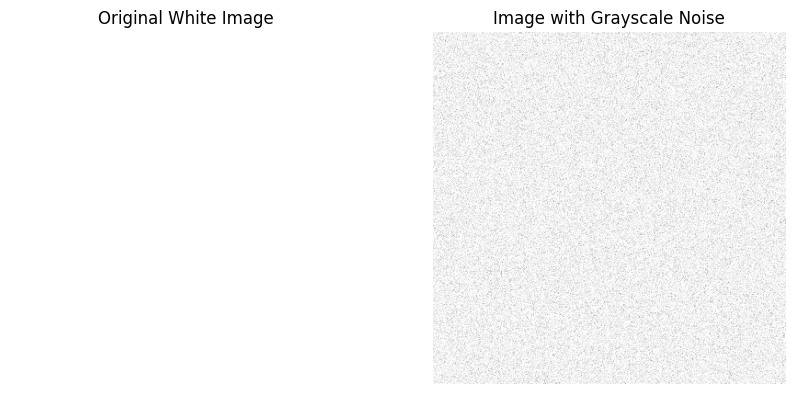

In [1]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np

# 단색의 흰색 이미지 생성
img = 255 * np.ones((384, 384, 3), dtype=np.uint8)

# 이미지 그레이스케일 변환 함수 (추가 인자 무시)
def to_grayscale(image, **kwargs):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 3채널로 복원하여 가우시안 노이즈 추가 시 색상 변형을 방지
    return cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)

# Albumentations 변환 설정 (그레이스케일 변환 및 가우시안 노이즈 추가)
transform = A.Compose([
    A.GaussNoise(var_limit=(1500.0, 1500.0), mean=0, p=1.0),  # 가우시안 노이즈 추가
    A.Lambda(image=to_grayscale, p=1.0),  # 그레이스케일 변환
    
])

# 이미지에 변환 적용
augmented = transform(image=img)
noisy_image = augmented['image']
cv2.imwrite('./graynoise.jpg', cv2.cvtColor(noisy_image, cv2.COLOR_RGB2BGR))

# 원본 이미지와 노이즈가 추가된 이미지 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original White Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Grayscale Noise')
plt.imshow(noisy_image)
plt.axis('off')

plt.show()


# 문서 제목만 크롭해서 저장하기

In [4]:
import os
from PIL import Image
import pandas as pd

# 경로 설정
input_dir = './data/train'
output_dir = './data/cropped_images'
input_csv = './data/train.csv'
output_csv = './data/cropped_images.csv'

# 새로운 폴더 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 크롭할 클래스 리스트
classes_to_crop = [1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15]

# CSV 파일 읽기
df = pd.read_csv(input_csv)

# 새로운 CSV 파일에 기록할 리스트 초기화
cropped_data = []

# 각 행에 대해 반복
for index, row in df.iterrows():
    file_name = row['ID']
    target = row['target']

    # 클래스가 지정된 리스트에 있는 경우 크롭 수행
    if target in classes_to_crop:
        image_path = os.path.join(input_dir, file_name)

        # 이미지 열기
        with Image.open(image_path) as image:
            width, height = image.size
            crop_height = int(height * 0.15)

            # 이미지 크롭
            cropped_image = image.crop((0, 0, width, crop_height))

            # 크롭된 이미지 저장
            cropped_file_name = f'cropped_{file_name}'
            cropped_image_path = os.path.join(output_dir, cropped_file_name)
            cropped_image.save(cropped_image_path)

            # 새로운 CSV 파일에 기록할 데이터 추가
            cropped_data.append({'ID': cropped_file_name, 'target': target})

# 새로운 CSV 파일 저장
cropped_df = pd.DataFrame(cropped_data)
cropped_df.to_csv(output_csv, index=False)

print(f"크롭된 이미지를 {output_dir}에 저장하고, {output_csv}에 정보를 기록하였습니다.")


크롭된 이미지를 ./data/cropped_images에 저장하고, ./data/cropped_images.csv에 정보를 기록하였습니다.


# 크롭한 이미지 크기 맞추기

In [6]:
from PIL import Image, ImageOps
import pandas as pd
import os

# 경로 설정
input_dir = './data/train'
output_dir = './data/cropped_and_padded_images'
input_csv = './data/train.csv'
output_csv = './data/cropped_and_padded_images.csv'

# 새로운 폴더 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 크롭할 클래스 리스트
classes_to_crop = [1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15]

# CSV 파일 읽기
df = pd.read_csv(input_csv)

# 패딩을 추가하여 맞출 최종 이미지 크기
# final_size = (128, 128)

# 새로운 CSV 파일에 기록할 리스트 초기화
processed_data = []

# 각 행에 대해 반복
for index, row in df.iterrows():
    file_name = row['ID']
    target = row['target']

    # 클래스가 지정된 리스트에 있는 경우 크롭 및 패딩 수행
    if target in classes_to_crop:
        image_path = os.path.join(input_dir, file_name)

        # 이미지 열기
        with Image.open(image_path) as image:
            width, height = image.size
            crop_height = int(height * 0.15)

            # 이미지 크롭 (윗부분)
            cropped_image = image.crop((0, 0, width, crop_height))

            # 패딩 추가하여 이미지 크기 맞추기
            padded_image = ImageOps.pad(cropped_image, image.size, color='white', centering=(0.5, 0))

            # 크롭된 및 패딩된 이미지 저장
            processed_file_name = f'padded_{file_name}'
            processed_image_path = os.path.join(output_dir, processed_file_name)
            padded_image.save(processed_image_path)

            # 새로운 CSV 파일에 기록할 데이터 추가
            processed_data.append({'ID': processed_file_name, 'target': target})

# 새로운 CSV 파일 저장
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv(output_csv, index=False)

print(f"패딩된 이미지를 {output_dir}에 저장하고, {output_csv}에 정보를 기록하였습니다.")


패딩된 이미지를 ./data/cropped_and_padded_images에 저장하고, ./data/cropped_and_padded_images.csv에 정보를 기록하였습니다.


# test 데이터 디노이징 테스트

[[[ 209.            0.34906584]]

 [[ 211.            0.34906584]]

 [[-115.            1.9198622 ]]

 [[ 328.            1.9198622 ]]

 [[ 142.            0.34906584]]

 [[ 237.            0.34906584]]

 [[ 262.            0.34906584]]

 [[ 235.            0.34906584]]

 [[ 159.            0.34906584]]

 [[ 156.            0.34906584]]]
Processed image saved to: processed_image.jpg


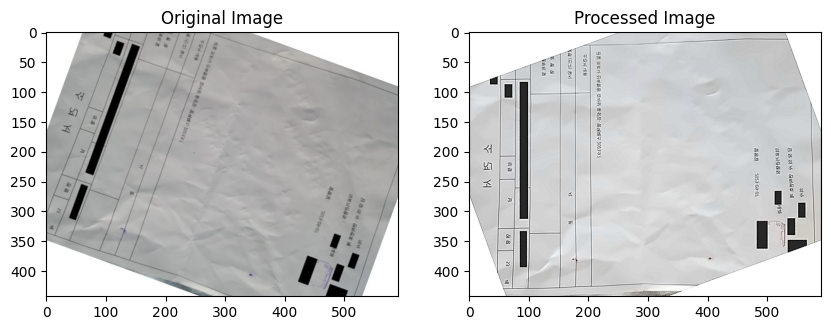

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def load_image(image_path):
    # 이미지 로드
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return image

def denoise_image(image):
    # 노이즈 제거 (비등방성 필터)
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 3, 10, 7, 21)
    return denoised

def correct_skew(image):
    # 이미지 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # 확률적 허프 변환을 사용하여 선 감지
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        for rho, theta in lines[2]:
            angle = (theta * 180 / np.pi)-90

    print(lines)

    if angle < -45:
        angle = (90 + angle)
    else:
        angle = angle

    # 회전 행렬 계산
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 새 이미지 크기 계산 (여유 공간 추가)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
 
    # 회전 행렬 조정 (중심점 변경)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # 이미지 회전 및 크기 조정
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    # # # 중심 부분을 원래 이미지 크기로 자르기
    # start_x = np.abs(new_w - w) // 2
    # start_y = np.abs(new_h - h) // 2
    # cropped = rotated[start_y:start_y + h, start_x:start_x + w]
    
    return rotated

def adjust_contrast_brightness(image, alpha=1., beta=40):
    # 명암 및 밝기 조정
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def sharpen_image(image):
    # 이미지 선명화
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def binarize_image(image):
    # 이미지 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 적응형 이진화 적용
    binarized = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return binarized

def trim_image(image):
    # 이미지 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화 - 배경과 텍스트를 분리
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # 윤곽선 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found!")
        return image

    # 가장 큰 윤곽선으로 바운딩 박스 계산
    all_contours = np.concatenate(contours)
    x, y, w, h = cv2.boundingRect(all_contours)

    # 이미지 자르기
    trimmed = image[y:y+h, x:x+w]

    return trimmed

def process_image(image_path):
    # 이미지 로드
    image = load_image(image_path)

    # 이미지 전처리 및 복원
    denoised = denoise_image(image)
    deskewed = correct_skew(denoised)
    contrasted = adjust_contrast_brightness(deskewed)
    sharpened = sharpen_image(contrasted)
    trimmed = trim_image(sharpened)
    
    return trimmed
# 이미지 경로 설정
image_path = "./data/test/09447bf11a0500aa.jpg"  # 흐릿한 이미지 경로
# image_path = "./data/test/0298c2151b43d86b.jpg"  # 흐릿한 이미지 경로

processed_image = process_image(image_path)

# 처리된 이미지 저장
output_path = "processed_image.jpg"
cv2.imwrite(output_path, processed_image)
print(f"Processed image saved to: {output_path}")

# 이미지 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(load_image(image_path), cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Processed Image")
plt.imshow(processed_image, cmap='gray')
plt.show()


# test 데이터 디노이징 전처리 후 test_modify폴더에 저장.

In [134]:
from PIL import Image, ImageOps
import pandas as pd
import os

# 경로 설정
input_dir = './data/test'
output_dir = './data/test_modify'
input_csv = './ensemble_pred.csv'

# 새로운 폴더 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 크롭할 클래스 리스트
classes_to_crop = [1, 3, 4, 6, 7, 10,11, 12, 13, 14, 15]

# CSV 파일 읽기
df = pd.read_csv(input_csv)

def load_image(image_path):
    # 이미지 로드
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return image

def denoise_image(image):
    # 노이즈 제거 (비등방성 필터)
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 3, 10, 7, 21)
    return denoised

def correct_skew(image):
    # 이미지 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # 확률적 허프 변환을 사용하여 선 감지
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        try:
            for rho, theta in lines[1]:
                angle = (theta * 180 / np.pi)-90
        except:
            for rho, theta in lines[0]:
                angle = (theta * 180 / np.pi)-90

    if angle < -45:
        angle = (90 + angle)
    else:
        angle = angle

    # 회전 행렬 계산
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 새 이미지 크기 계산 (여유 공간 추가)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # 회전 행렬 조정 (중심점 변경)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # 이미지 회전 및 크기 조정
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    
    return rotated

def adjust_contrast_brightness(image, alpha=1., beta=40):
    # 명암 및 밝기 조정
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def sharpen_image(image):
    # 이미지 선명화
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def binarize_image(image):
    # 이미지 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 적응형 이진화 적용
    binarized = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return binarized

def trim_image(image):
    # 이미지 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화 - 배경과 텍스트를 분리
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # 윤곽선 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found!")
        return image

    # 가장 큰 윤곽선으로 바운딩 박스 계산
    all_contours = np.concatenate(contours)
    x, y, w, h = cv2.boundingRect(all_contours)

    # 이미지 자르기
    trimmed = image[y:y+h, x:x+w]

    return trimmed

def process_image(image_path):
    # 이미지 로드
    image = load_image(image_path)

    # 이미지 전처리 및 복원
    denoised = denoise_image(image)
    deskewed = correct_skew(denoised)
    contrasted = adjust_contrast_brightness(deskewed)
    sharpened = sharpen_image(contrasted)
    trimmed = trim_image(sharpened)
    
    return trimmed

# 각 행에 대해 반복
for index, row in df.iterrows():
    file_name = row['ID']
    target = row['target']
    image_path = os.path.join(input_dir, file_name)
    print(f"Processed image saved to: {index}")

    # 클래스가 지정된 리스트에 있는 경우 크롭 및 패딩 수행
    if target in classes_to_crop:

        processed_image = process_image(image_path)

        with Image.open(image_path) as image:
            width, height = image.size
            
            # 크롭된 및 패딩된 이미지 저장
            # processed_file_name = f'padded_{file_name}'
            processed_image_path = os.path.join(output_dir, file_name)
            cv2.imwrite(processed_image_path,processed_image)

            # 새로운 CSV 파일에 기록할 데이터 추가
            processed_data.append({'ID': processed_file_name, 'target': target})
    else:
        image = load_image(image_path)
        processed_image_path = os.path.join(output_dir, file_name)
        cv2.imwrite(processed_image_path,image)

print(f"패딩된 이미지를 {output_dir}에 저장")

Processed image saved to: 0
Processed image saved to: 1
Processed image saved to: 2
Processed image saved to: 3
Processed image saved to: 4
Processed image saved to: 5
Processed image saved to: 6
Processed image saved to: 7
Processed image saved to: 8
Processed image saved to: 9
Processed image saved to: 10
Processed image saved to: 11
Processed image saved to: 12
Processed image saved to: 13
Processed image saved to: 14
Processed image saved to: 15
Processed image saved to: 16
Processed image saved to: 17
Processed image saved to: 18
Processed image saved to: 19
Processed image saved to: 20
Processed image saved to: 21
Processed image saved to: 22
Processed image saved to: 23
Processed image saved to: 24
Processed image saved to: 25
Processed image saved to: 26
Processed image saved to: 27
Processed image saved to: 28
Processed image saved to: 29
Processed image saved to: 30
Processed image saved to: 31
Processed image saved to: 32
Processed image saved to: 33
Processed image saved to

In [ ]:
from transformers import SwinForImageClassification, SwinConfig
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import torch

# Swin Transformer 모델 설정
config = SwinConfig(
    image_size=224,        # 입력 이미지 크기
    patch_size=4,          # 패치 크기
    num_labels=1000,       # 분류할 클래스 수
    embed_dim=96,          # 임베딩 차원
    depths=[2, 2, 6, 2],   # 각 스테이지의 레이어 수
    num_heads=[3, 6, 12, 24], # 각 스테이지의 멀티 헤드 수
    window_size=7,         # 윈도우 크기
    mlp_ratio=4.0,         # MLP 확장 비율
    drop_rate=0.0,         # 드롭아웃 비율
    attn_drop_rate=0.0,    # 어텐션 드롭아웃 비율
    drop_path_rate=0.1     # 스토캐스틱 딥스 비율
)

# Swin Transformer 모델 초기화
model = SwinForImageClassification(config)

# 모델 정보 출력
print(model)
